In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [2]:
from workers.utils.misc import load_yaml, wrapper

In [3]:
log_dir = 'workers/logs/'
log_files = os.listdir(log_dir)

In [4]:
def worker_coords():
    
    # FETCH FILES
    log_dir = 'workers/logs/'
    log_files = os.listdir(log_dir)
    
    col_refs = {
        'iot': '#e75f5b',
        'edge': '#f2ae42',
        'storage': '#52af52'
    }
    
    x=[]
    y=[]
    colors=[]
    
    # ['#f2ae42', '#a93581', '#ffc0cb', '#928478']
    
    # LOOP THROUGH
    for log_file in log_files:
        result = load_yaml(log_dir + log_file)

        try:
            coords = result.details.location
            
            x.append(coords.x)
            y.append(coords.y)
            colors.append(col_refs[result.details.worker])
        except:
            pass
            
    return x, y, colors

In [5]:
def find_closest(target, nodes):
    best_node = None
    best_distance = float('inf')

    # NO EDGES EXIST
    if len(nodes) == 0:
        return best_node

    # FIND THE CLOSEST
    for node in nodes:

        # COMPUTE STRAIGHT LINE DISTANCE
        P1 = abs(target.location.x - node.location.x)**2
        P2 = abs(target.location.y - node.location.y)**2
        distance = math.sqrt(P1 + P2)

        # UPDATE WHEN A BETTER DISTANCE IS FOUND
        if distance < best_distance:
            best_node = node
            best_distance = distance

    return best_node.location

In [6]:
def generate_dataset(iot_count, edge_count, storage_count=1):
    iots, edges, storages = [], [], []
    
    smallest = 0+0.5
    largest = 10-0.5
    
    for _ in range(iot_count):
        iots.append(wrapper({
            'type': 'iot',
            'location': {
                'x': np.random.uniform(smallest, largest),
                'y': np.random.uniform(smallest, largest)
            },
            'edge': None
        }))
        
    for _ in range(edge_count):
        edges.append(wrapper({
            'type': 'edge',
            'location': {
                'x': np.random.uniform(smallest, largest),
                'y': np.random.uniform(smallest, largest)
            },
            'storage': None
        }))
        
    for _ in range(storage_count):
        storages.append(wrapper({
            'type': 'storage',
            'location': {
                'x': np.random.uniform(smallest, largest),
                'y': np.random.uniform(smallest, largest)
            }
        }))
        
    for iot in iots:
        closest = find_closest(iot, edges)
        iot.edge = closest
        
    for edge in edges:
        closest = find_closest(edge, storages)
        edge.storage = closest
        
    return iots, edges, storages

In [47]:
def extract_coords(iots, edges, storages):
    xs, ys, colors, sizes = [], [], [], []
    
    col_refs = {
        'iot': '#e75f5b',
        'edge': '#3378ca',
        'storage': '#52af52'
    }

    for iot in iots:
        xs.append(iot.location.x)
        ys.append(iot.location.y)
        colors.append(col_refs['iot'])
        sizes.append(50)

    for edge in edges:
        xs.append(edge.location.x)
        ys.append(edge.location.y)
        colors.append(col_refs['edge'])
        sizes.append(200)

    for storage in storages:
        xs.append(storage.location.x)
        ys.append(storage.location.y)
        colors.append(col_refs['storage'])
        sizes.append(100)
        
    xs.append(np.random.uniform(3, 6))
    ys.append(np.random.uniform(3, 6))
    colors.append('#928478')
    sizes.append(300)
        
    return xs, ys, colors, sizes

In [48]:
def create_map(iot_count, edge_count, storage_count=1):
    
    # CREATE DATASET FROM LOG FILES
    iots, edges, storages = generate_dataset(iot_count, edge_count, storage_count)
    xs, ys, colors, sizes = extract_coords(iots, edges, storages)
    
    service_coords = wrapper({
        'x': xs[-1],
        'y': ys[-1],
    })
    
    col_refs = {
        'iot': '#e75f5b',
        'edge': '#3378ca',
        'storage': '#52af52'
    }

    # SETTINGS
    limit = 10
    line_opacity = 0.5
    line_width = 1
    
    # CREATE FIGURE
    fig, ax = plt.subplots(figsize=(limit, limit), dpi=100)
    
    # DRAW DOTS
    ax.scatter(xs, ys, s=sizes, c=colors, alpha=0.95, zorder=10, vmin=0, vmax=100)

    ax.set(
        xlim=(0, limit), xticks=np.arange(0, limit),
        ylim=(0, limit), yticks=np.arange(0, limit)
    )
    
    # DRAW IOT => EDGE LINES
    for iot in iots:
        x = [iot.location.x, iot.edge.x]
        y = [iot.location.y, iot.edge.y]
        ax.plot(x, y, '-', color=col_refs['iot'], linewidth=line_width, alpha=line_opacity)
        ax.plot([iot.location.x, service_coords.x], [iot.location.y, service_coords.y], '-', color='gray', linewidth=line_width, alpha=0.2)
        
    # DRAW EDGE => STORAGE LINES
    for edge in edges:
        x = [edge.location.x, edge.storage.x]
        y = [edge.location.y, edge.storage.y]
        ax.plot(x, y, '-', color=col_refs['edge'], linewidth=line_width, alpha=line_opacity)
        ax.plot([edge.location.x, service_coords.x], [edge.location.y, service_coords.y], '-', color='gray', linewidth=line_width, alpha=0.1)
        
    for storage in storages:
        ax.plot([storage.location.x, service_coords.x], [storage.location.y, service_coords.y], '-', color='gray', linewidth=line_width, alpha=0.1)
    
    # IOT ANNOTATIONS
    for iot in iots:
        ax.annotate(iot.type.upper(), (iot.location.x - 0.12, iot.location.y + 0.15))
        
    # EDGE ANNOTATIONS
    for edge in edges:
        ax.annotate(edge.type.upper(), (edge.location.x - 0.23, edge.location.y + 0.22))
        
    # STORAGE ANNOTATIONS
    for storage in storages:
        ax.annotate(storage.type.upper(), (storage.location.x - 0.43, storage.location.y + 0.15))
    
    # SERVICE ANNOTATION
    ax.annotate('SERVICE', (service_coords.x - 0.38, service_coords.y + 0.24))

    plt.grid(linewidth=0.5, alpha=0.2)
    plt.show()

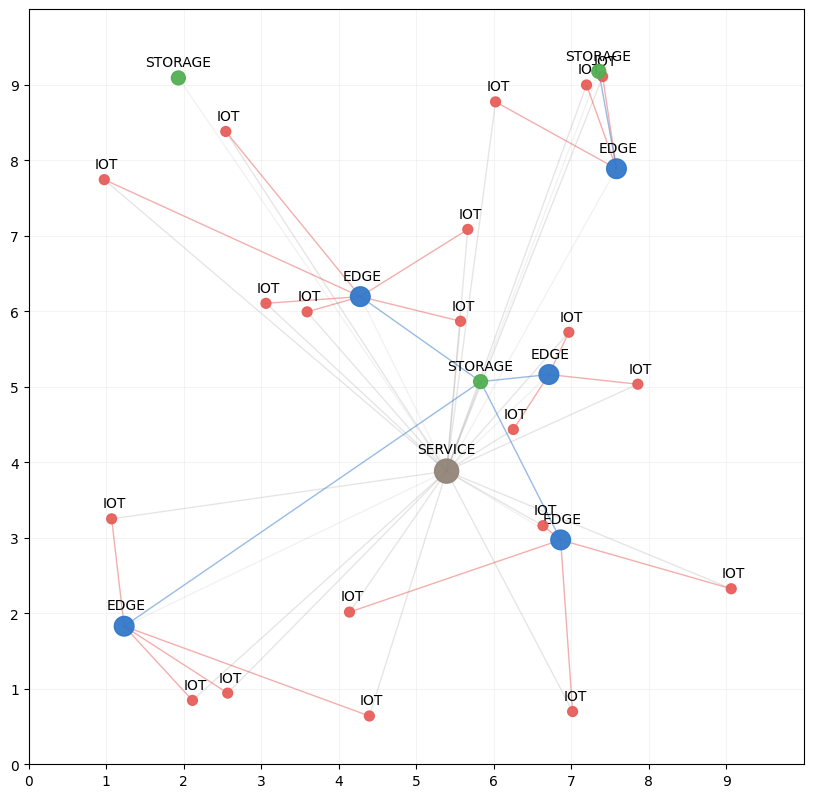

In [57]:
create_map(20, 5, 3)